In part_1, I made a pandas DataFrame with one row for each game played in the last 100 years for each player in the game (about 4.4M rows).  The columns are the batting line numbers for that player in that game, with a bunch of modern stats added by Sean Lahman, who curates the data, which was pulled from baseball-reference.com.

The goal is to look at the first 55-60 games for each season and see what sorts of stats get put up, for comparison with the COV19-shortened 2020 season stats, and to get a better grasp of the variance of some stats.  For instance, it's intuitive that summation stats like total home runs or total strikeouts should be higher in a 60-game season than $\frac{60}{162}$ of the same stat for a 162-game season.  But by how much?

Stats that are averaged by something like the number of plate appearances for the hitter should maybe have less variance, and be closer to a normal season's stats.  Maybe.  It could be hard to directly calculate the actual variance of all these per-player stats even for a normal season, because so many players have so few at-bats compared to other players.  But it does seem that, by looking at the first 55-60 games of each season and seeing how far off the stats are from a prorated portion of that full season's stats, we could get a good idea of how much variance there is in each stat.  And then when the 2020 "regular" season ends in a few weeks, we could get a better idea of how batter stats might have ended up with 100 more games, and how they stack up with the first part of each of the last 100 seasons.

It was interesting, to me, to think about which batches of games to compare to 2020.  My first thought was to look at every 60-game stretch in history, within single seasons.  So for a 162-game season, there would be 103 such spans, for each player. There would be huge overlaps between the spans, and the very best and worst streaks would surface, and would have little value serving as yardsticks for a fixed window like 2020's schedule.  The first 60 games seem like a better comparison, but you could also make a case for the last 60 games of each season instead.  The teams in contention for the playoffs are playing as they would at the end of a normal season, and the calendar days are the same as the ends of normal seasons (i.e. August and September weather, light, etc.).  Maybe the best comparison is against 200 samples:  100 season beginnings and 100 season endings. But I'll just look at the first 60 games for now....

Finally, there's the question of whether 60 games is the right sample size at all.  In 2020, there are some teams who had to miss 1-2 weeks of games due to league COV19 protocol.  As I start writing this, the Twins have played 45 games and the Marlins 35.  A couple of weeks later I come back to finish it, and the Marlins have caught up by playing a relentless stretch of doubleheaders, which are 6$\frac{1}{2}$ or 7 innings each this year instead of the usual 8$\frac{1}{2}$ or 9.  And extra innings are fewer this year due to temporary rule changes.  My hunch is that the first and/or last 55 games of a normal season would be a better comparison to this year, for individual player stats.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv('century_batting')
df.shape

(4421857, 41)

In [5]:
min(df.season)

1901

In [6]:
# got 1900-1919 in there still, so remove those years
df = df[df.season >= 1920]
df.shape

(4280224, 41)

Since the current focus is on individual stats, not team stats, I'll start by removing the batting lines for all pitchers, who would drag averages lower by mostly not being good hitters, and would even be outliers in summary stats, since they bat only a couple of times every 5 days.  Furthermore, when it comes to comparisons with 2020, pitchers aren't batting this year, even in the NL.  

In [7]:
df.columns

Index(['player', 'season', 'game', 'Gtm', '2B', '3B', 'AB', 'BA', 'BB', 'BOP',
       'CS', 'DFS(DK)', 'DFS(FD)', 'Date', 'GDP', 'Gcar', 'H', 'HBP', 'HR',
       'IBB', 'Inngs', 'OBP', 'OPS', 'Opp', 'PA', 'Pos', 'R', 'RBI', 'RE24',
       'ROE', 'Rslt', 'SB', 'SF', 'SH', 'SLG', 'SO', 'Tm', 'WPA', 'aLI', 'LOC',
       'name'],
      dtype='object')

In [8]:
df = df[df.Pos != 'P']
df.shape

(3604281, 41)

The 2 George Burnses of the 1920's, 2 Hal Smiths in the 1950's, 2 Ken Griffeys who overlapped in 1989-1991, the 2 Brian Hunters from 1994-1999, the 2 Luis Gonzalezes and the 2 Alex Gonzalezes playing simultaneously around 2000, all mess up the cumulative stats for those eras, if you use their name/season combos as indexes, but I didn't catch that when originally building the dataset, so need to change it now.

In [171]:
df[df.name == 'Alex Gonzalez'].player.unique()

array(['gonzaal01', 'gonzaal02'], dtype=object)

In [236]:
df[df.name == 'Luis Gonzalez'].player.unique()

array(['gonzalu01', 'gonzalu02'], dtype=object)

In [237]:
df[df.name == 'Ken Griffey'].player.unique()

array(['griffke01', 'griffke02'], dtype=object)

In [238]:
df[df.name == 'Brian Hunter'].player.unique()

array(['huntebr01', 'huntebr02'], dtype=object)

In [282]:
df[df.name == 'George Burns'].player.unique()

In [278]:
df[df.name == 'Hal Smith'].player.unique()

array(['smithha08', 'smithha09'], dtype=object)

In [254]:
names = df.name.values
for i, player in enumerate(df.player.values):
    if player in ['burnsge02', 'gonzaal02', 'griffke02', 'huntebr02', 'gonzalu02', 'smithha09']:
        names[i] += ' (2)'

df['name'] = names

In [283]:
df.to_csv('century_batting')

#### To begin, how about a quick peek at some of the statistics and how to filter and calculate them....

How many team-games are these, for a century?

In [140]:
# half of this number is the number of actual games
df.groupby(['season', 'game', 'Tm']).ngroups   

351334

How many at-bats do positional players get each game?

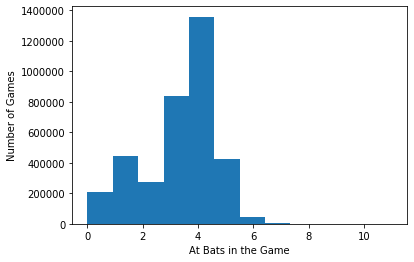

In [420]:
plt.hist(df.AB, bins=12)
plt.xlabel('At Bats in the Game')
plt.ylabel('Number of Games');

Most fans would probably have guessed correctly that 4 AB was most common.  The fact that there are more cases of 1 AB than of 2 AB probably reflects the fact that pinch hitters are usually used late in the game.

What's the game count by position?

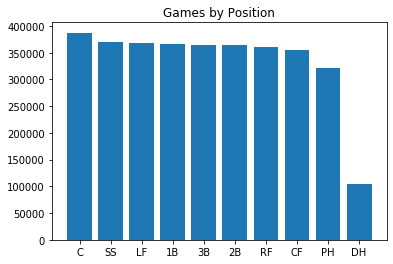

In [142]:
top_pos = df.Pos.value_counts()[:10]
plt.bar(range(len(top_pos)), height=top_pos.values, tick_label=top_pos.keys())
plt.title('Games by Position');

Catchers have the most games in that chart, so they get replaced more often than other positions do during games.  Either they get banged up more or they get pinch hit for more, perhaps?

If catchers are getting pinch hit for more often, does that mean their batting avg is worst?

In [372]:
positions = df.Pos.value_counts()[:10]
positions.keys()

Index(['C', 'SS', 'LF', '1B', '3B', '2B', 'RF', 'CF', 'PH', 'DH'], dtype='object')

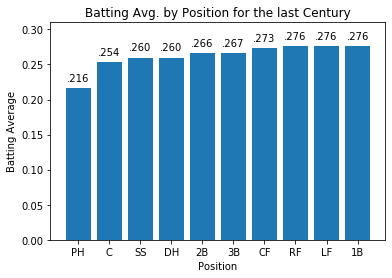

In [402]:
pos_groups = df.groupby('Pos')
# calculate the batting avg by hits/at-bats
ba = pos_groups.H.sum() / pos_groups.AB.sum()
plt.bar(*list(zip(*sorted([(p, ba[p]) for p in positions.keys()], key=lambda x: x[1]))))
plt.xlabel('Position')
plt.ylabel('Batting Average')
plt.ylim(0, .31)
for pos, stat in [(p, ba[p]) for p in positions.keys()]:
    plt.text(pos, stat + 0.01, ('%.3f' % stat).lstrip('0'), color='k', fontsize=10, horizontalalignment='center')
plt.title('Batting Avg. by Position for the last Century');

So yes, catchers have the worst batting average out of the 8 field players, but it's maybe surprising how much worse pinch hitters are, considering their role.

Probably the homerun situation isn't the same---

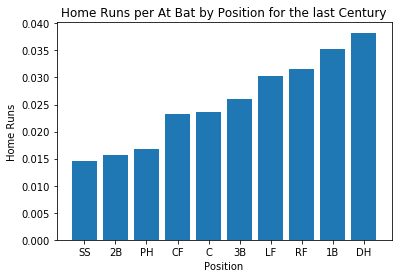

In [144]:
hr = pos_groups.HR.sum() / pos_groups.AB.sum()
plt.bar(*list(zip(*sorted([(p, hr[p]) for p in positions.keys()], key=lambda x: x[1]))))
plt.xlabel('Position')
plt.ylabel('Home Runs')
plt.title('Home Runs per At Bat by Position for the last Century');

Central positions like shortstops, second basemen, catchers, and center fielders are valuable less for their hitting than for their defense, compared to the other 4 field positions.

How have on-base % and slugging % evolved over the decades?

In [145]:
'''
OBP = (H + BB + HBP) / (AB + BB + HBP + SF) ==> on-base %, as stated on bb-ref site.  
total_bases = H + 2B + 2*3B + 3*HR  ==> since there's no "1B" column here
SLG = total_bases/ AB
OPS = OBP + SLG
'''

df['decade'] = pd.cut(df.season, range(1920, 2021, 10), include_lowest=True, right=False,
      labels=['20s','30s','40s','50s','60s','70s','80s','90s','00s','10s'])

In [91]:
def get_obp_slg(frame, grouping):
    '''Group the frame as specified and
    calculate the OBP and SLG for each group.
    '''
    groups = frame.groupby(grouping)
    obp = (groups.H.sum() + groups.BB.sum() + groups.HBP.sum()) / \
          (groups.AB.sum() + groups.BB.sum() + groups.HBP.sum() + groups.SF.sum())
    slg = (groups.H.sum() + groups['2B'].sum() + 2*groups['3B'].sum()
          + 3*groups['HR'].sum()) / groups.AB.sum()
    return obp, slg

In [196]:
def get_ba_obp_slg(frame, grouping):
    '''Group the frame as specified and
    calculate the BA, OBP, and SLG for each group.
    Same function as above, but with batting average as well.
    '''
    groups = frame.groupby(grouping)
    ba = groups.H.sum() / groups.AB.sum()
    obp = (groups.H.sum() + groups.BB.sum() + groups.HBP.sum()) / \
          (groups.AB.sum() + groups.BB.sum() + groups.HBP.sum() + groups.SF.sum())
    slg = (groups.H.sum() + groups['2B'].sum() + 2*groups['3B'].sum()
          + 3*groups['HR'].sum()) / groups.AB.sum()
    return ba, obp, slg

In [153]:
obp, slg = get_obp_slg(df, 'decade')

In [154]:
ops = obp + slg

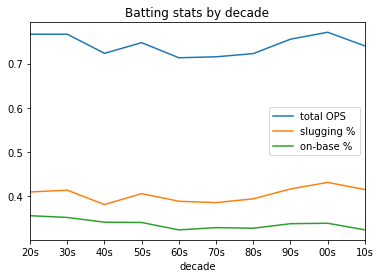

In [155]:
ops.plot(label='total OPS')
slg.plot(label='slugging %')
obp.plot(label='on-base %')
plt.legend()
plt.title('Batting stats by decade');

Those stats are more even over time than I expected.  The 1950's saw an uptick in slugging, as did the 1990's and 2000's.  From this bird's eye view, when you pool every hitter together for a decade, the OPS stat favored these days looks redundant with its slugging component.

How much more variance will there be if we look at each year instead of each decade?

In [93]:
obp, slg = get_obp_slg(df, 'season')
ops = obp + slg

In [439]:
ba = df.groupby('season').H.sum() / df.groupby('season').AB.sum()
league_seasons = pd.DataFrame({'ba':ba, 'obp':obp, 'slg':slg, 'ops':ops, 
                               'ba60':ba60, 'obp60':obp60, 'slg60':slg60, 'ops60':ops60})
league_seasons.head()

,ba,obp,slg,ops,ba60,obp60,slg60,ops60
season,,,,,,,,
1920,0.283592,0.343101,0.383374,0.726475,0.279851,0.344723,0.377911,0.722635
1921,0.298700,0.357128,0.415396,0.772524,0.300678,0.360022,0.425101,0.785122
1922,0.297007,0.358802,0.415190,0.773993,0.292649,0.358506,0.413640,0.772146
1923,0.291604,0.356404,0.404361,0.760766,0.288008,0.356118,0.404086,0.760204
1924,0.293529,0.356345,0.405785,0.762130,0.289011,0.353715,0.400434,0.754149


In [440]:
league_seasons.to_csv('MLB_chartstats/leaguewide_avgs')

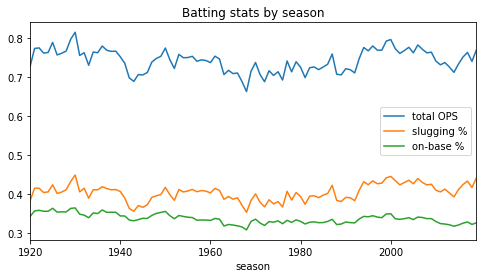

In [157]:
plt.figure(figsize=(8, 4))
ops.plot(label='total OPS')
slg.plot(label='slugging %')
obp.plot(label='on-base %')
plt.legend()
plt.title('Batting stats by season');

Compare the first 60 games of every season to the full season, for league-wide OPS:

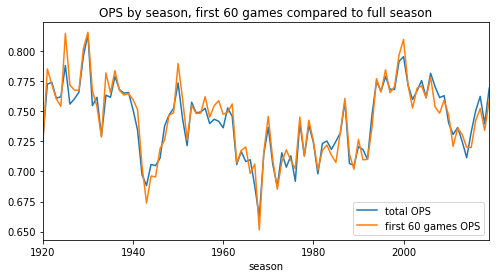

In [298]:
ba60, obp60, slg60 = get_ba_obp_slg(df[df.game < 61], 'season')
ops60 = obp60 + slg60
plt.figure(figsize=(8, 4))
ops.plot(label='total OPS')
ops60.plot(label='first 60 games OPS')
plt.legend()
plt.title('OPS by season, first 60 games compared to full season');

In [168]:
# std dev of 100 seasons league-wide OPS, first 60 games only
ops60.std()

0.031070355855497157

In [169]:
# same stat, but for full seasons
ops.std()

0.028848198559932967

In [10]:
df.columns


Index(['player', 'season', 'game', 'Gtm', '2B', '3B', 'AB', 'BA', 'BB', 'BOP',
       'CS', 'DFS(DK)', 'DFS(FD)', 'Date', 'GDP', 'Gcar', 'H', 'HBP', 'HR',
       'IBB', 'Inngs', 'OBP', 'OPS', 'Opp', 'PA', 'Pos', 'R', 'RBI', 'RE24',
       'ROE', 'Rslt', 'SB', 'SF', 'SH', 'SLG', 'SO', 'Tm', 'WPA', 'aLI', 'LOC',
       'name'],
      dtype='object')

Let's see how common batting leader stats for the first 60 games look

In [284]:
first60 = df[df.game < 61]
first60.shape

(1356709, 41)

In [441]:
grouped = first60.groupby(['season', 'name'])
# do full seasons for comparisons:
full_grouped = df.groupby(['season', 'name'])

In [461]:
batcats = ['2B', '3B', 'BA', 'BB', 'H', 'HR', 'R', 'RBI', 'SO', 'PA']
for cat in batcats:
    leaders60 = grouped.sum()[cat].sort_values(ascending=False)[:30]
    leaders = full_grouped.sum()[cat].sort_values(ascending=False)[:30]
    leaders60.to_csv(f'MLB_chartstats/leaders60{cat}.csv')
    leaders.to_csv(f'MLB_chartstats/leaders{cat}.csv')

/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """
/Users/ethanhaley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [459]:
print('Luke Voit hit 22 homeruns in 2020.  \nHere are the top season starts historically:')

pd.DataFrame(grouped.HR.sum().sort_values(ascending=False)[:30])
                                                                                                               

Luke Voit hit 22 homeruns in 2020.  
Here are the top season starts historically:


,,HR
season,name,
2001,Barry Bonds,32
1998,Mark McGwire,28
1928,Babe Ruth,27
1956,Mickey Mantle,27
1969,Reggie Jackson,26
2006,Albert Pujols,25
1997,Ken Griffey (2),25
1994,Ken Griffey (2),25
2000,Barry Bonds,25


Here's just the top number per season's start:

In [202]:
def plot_2020_vs_historical(groups, stat, stat_2020, name_2020, ylab, title):
    plt.scatter(range(1920, 2020), groups[stat].sum().groupby('season').max(),
               label='', facecolors='none', edgecolors='k')
    plt.axhline(stat_2020, c='y', label=name_2020 + ' 2020')
    plt.ylabel(ylab)
    plt.xlabel('season')
    plt.grid(alpha=0.5)
    plt.legend()
    plt.title(title);

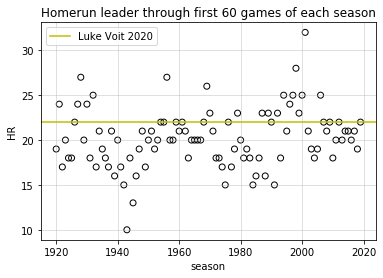

In [259]:
plot_2020_vs_historical(grouped, 'HR', 22, 'Luke Voit', 'HR', 
                        'Homerun leader through first 60 games of each season')

#### Luke Voit's 22 HR in 2020 were the same number hit by last year's early-season leader, and at the upper end of the range for the last 10 years.  So it's a solid number, but not historically unusual, although if you discount the steroid years around 2000, it looks even better.

In [404]:
print('José Abreu had 60 Runs Batted In in 2020. \nHere are the top season starts historically:')
pd.DataFrame(grouped.RBI.sum().sort_values(ascending=False)[:30])

José Abreu had 60 Runs Batted In in 2020. 
Here are the top season starts historically:


,,RBI
season,name,
1938,Jimmie Foxx,78.0
1929,Al Simmons,77.0
1930,Chuck Klein,77.0
1926,Babe Ruth,76.0
1998,Juan Gonzalez,76.0
1935,Hank Greenberg,75.0
1930,Lou Gehrig,73.0
1929,Mel Ott,73.0
1999,Manny Ramirez,72.0


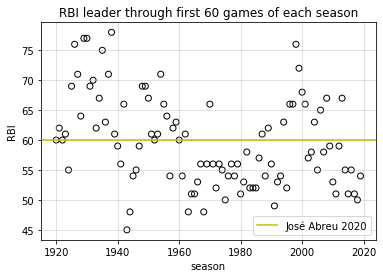

In [261]:
plot_2020_vs_historical(grouped, 'RBI', 60, 'José Abreu', 'RBI', 
                       'RBI leader through first 60 games of each season')

#### As with homeruns, the 60 RBI of José Abreu are impressive compared to most of the last 10 seasons, but somewhat in the middle of the historic pack.

In [405]:
print('Kyle Tucker had 6 triples in 2020.  \nHere are the top season starts historically:')
pd.DataFrame(grouped["3B"].sum().sort_values(ascending=False)[:30])

Kyle Tucker had 6 triples in 2020.  
Here are the top season starts historically:


,,3B
season,name,
1927,Paul Waner,13
1926,Lou Gehrig,12
2007,Curtis Granderson,12
1926,Glenn Wright,12
1921,Ty Cobb,12
1929,Lloyd Waner,11
2011,Jose Reyes,11
1930,Kiki Cuyler,11
1977,Rod Carew,11


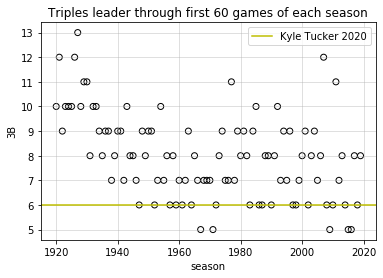

In [263]:
plot_2020_vs_historical(grouped, '3B', 6, 'Kyle Tucker', '3B',
                       'Triples leader through first 60 games of each season')

#### Kyle Tucker's 6 triples are towards the bottom of the historic range.

In [406]:
print('Freddie Freeman hit 23 doubles in 2020.  \nHere are the top season starts historically:')
pd.DataFrame(grouped["2B"].sum().sort_values(ascending=False)[:30])

Freddie Freeman hit 23 doubles in 2020.  
Here are the top season starts historically:


,,2B
season,name,
1932,Paul Waner,33
1996,Edgar Martinez,32
1995,Mark Grace,32
2001,Mike Sweeney,29
1931,Earl Webb,29
2007,Magglio Ordonez,29
1994,Larry Walker,28
1925,Frank O'Rourke,28
1994,Chuck Knoblauch,28


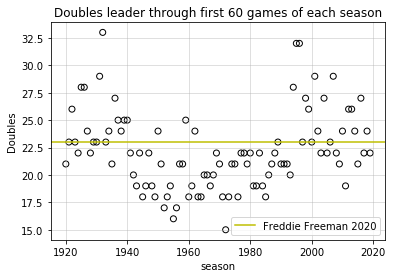

In [265]:
plot_2020_vs_historical(grouped, '2B', 23, 'Freddie Freeman', 'Doubles',
                       'Doubles leader through first 60 games of each season')

#### Freddie Freeman's 23 doubles were right about what you probably would've predicted if you studied historic stats.

In [407]:
print('Trea Turner had 78 hits in 2020. \nHere are the top season starts historically:')
pd.DataFrame(grouped["H"].sum().sort_values(ascending=False)[:30])

Trea Turner had 78 hits in 2020. 
Here are the top season starts historically:


,,H
season,name,
1922,George Sisler,109
1920,George Sisler,104
1934,Heinie Manush,102
1925,Al Simmons,101
1921,Ty Cobb,101
1930,Chuck Klein,101
1928,Taylor Douthit,101
2000,Darin Erstad,99
1921,Rogers Hornsby,98


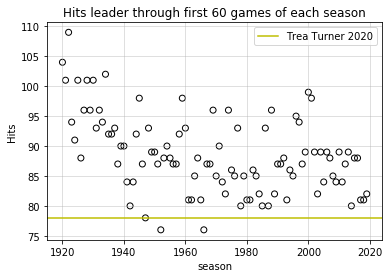

In [371]:
plot_2020_vs_historical(grouped, 'H', 78, 'Trea Turner', 'Hits', 
                       'Hits leader through first 60 games of each season')

#### Trea Turner's league-leading 78 hits in 2020 are lower than would probably be expected.  Only 2 years in the last century had a lower total for the league leader after 60 games.  With normal rules, the number would probably have been right in line with the last 3 years though, as we'll see below when we look at Plate Appearances.

In [408]:
print('Freddie Freeman scored 51 runs in 2020.  \nHere are the top season starts historically:')
pd.DataFrame(grouped["R"].sum().sort_values(ascending=False)[:30])

Freddie Freeman scored 51 runs in 2020.  
Here are the top season starts historically:


,,R
season,name,
1930,Babe Ruth,76
1936,Lou Gehrig,74
1925,Kiki Cuyler,72
1928,Babe Ruth,67
1994,Frank Thomas,66
1932,Chuck Klein,65
1927,Babe Ruth,65
1921,Ty Cobb,65
1926,Babe Ruth,64


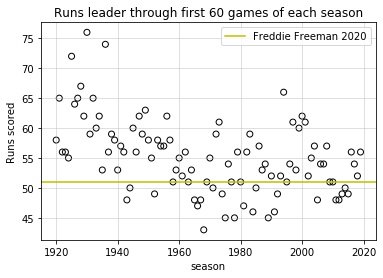

In [273]:
plot_2020_vs_historical(grouped, 'R', 51, 'Freddie Freeman', 'Runs scored',
                        'Runs leader through first 60 games of each season')

#### 51 runs through 60 games is right in line with past years.

In [409]:
print('Bryce Harper walked 49 times in 2020.  \nHere are the top season starts historically:')
pd.DataFrame(grouped['BB'].sum().sort_values(ascending=False)[:30])

Bryce Harper walked 49 times in 2020.  
Here are the top season starts historically:


,,BB
season,name,
2004,Barry Bonds,82
1947,Ted Williams,77
1923,Babe Ruth,74
1929,Max Bishop,71
1956,Eddie Yost,70
2002,Barry Bonds,70
1951,Ted Williams,69
1995,Frank Thomas,66
1946,Ted Williams,66


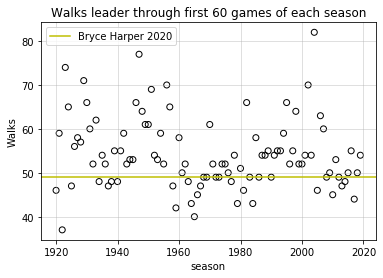

In [275]:
plot_2020_vs_historical(grouped, 'BB', 49, 'Bryce Harper', 'Walks', 
                       'Walks leader through first 60 games of each season')

#### Nothing unusual about 49 walks through 60 games, at least in the modern game.

In [410]:
print('Miguel Sano struck out 90 times in 2020.  \nHere are the worst season starts historically:')
pd.DataFrame(grouped["SO"].sum().sort_values(ascending=False)[:30])

Miguel Sano struck out 90 times in 2020.  
Here are the worst season starts historically:


,,SO
season,name,
2012,Adam Dunn,96
2017,Chris Davis,94
2009,Chris Davis,90
2016,Trevor Story,87
2018,Aaron Judge,86
2017,Miguel Sano,86
2016,Mike Napoli,86
2013,Chris Carter,85
2017,Joey Gallo,84


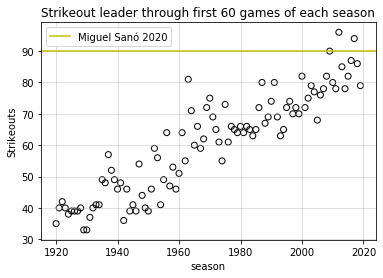

In [277]:
plot_2020_vs_historical(grouped, 'SO', 90, 'Miguel Sanó', 'Strikeouts', 
                       'Strikeout leader through first 60 games of each season')

#### Miguel Sanó and his 90 strikeouts through 60 short games are the perfect continuation of a long, steady, upward historical trend.  Sanó actually only played in 53 games, making his staggeringly bad number even worse.

#### A lot of the cumulative stats shown above may be artificially low due to the unusually high number of 7-inning doubleheader games played in 2020, as well as the new rules making extra innings more scarce.   We could check Plate Appearance totals to see if 2020 is in fact lower.

In [411]:
print('Marcell Ozuna led MLB with 267 Plate Appearances in 2020.  \nHere are the highest season starts historically:')
pd.DataFrame(grouped.PA.sum().sort_values(ascending=False)[:30])

Marcell Ozuna led MLB with 267 Plate Appearances in 2020.  
Here are the highest season starts historically:


,,PA
season,name,
1931,Earle Combs,300
1926,Mark Koenig,299
1929,Max Bishop,299
1936,Red Rolfe,298
1941,Dom DiMaggio,298
1957,Red Schoendienst,298
2003,Alfonso Soriano,296
1921,Jack Tobin,296
1939,Frankie Crosetti,296


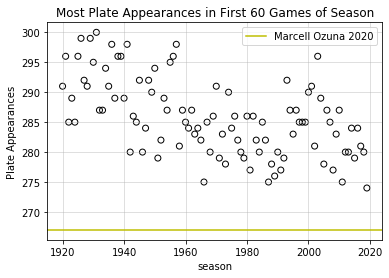

In [289]:
plot_2020_vs_historical(grouped, 'PA', 267, 'Marcell Ozuna', 'Plate Appearances', 
                       'Most Plate Appearances in First 60 Games of Season')

#### That shows a century-long, historical trend downwards, but 2020 definitely is distorted by COV-19 rule changes.  Cumulative stats like the ones shown in previous tables would all be something like 4% higher if rules hadn't changed.

For rate stats, like batting avg, the standard lower threshold to qualify for the leaderboard is 3.1 Plate Appearances per game, so 186 in 60 games.

In [290]:
minPA = grouped.filter(lambda x: x.PA.sum() > 185).groupby(['season','name'])

In [417]:
print('DJ LeMahieu hit .364 in 2020.  \nHere are the top season starts historically:')
(round((minPA.H.sum() / minPA.AB.sum()), 3).sort_values(ascending=False)).head(30).to_frame(name='BA')

DJ LeMahieu hit .364 in 2020.  
Here are the top season starts historically:


,,BA
season,name,
1922,George Sisler,0.443
1920,George Sisler,0.430
1925,Rogers Hornsby,0.429
1923,Harry Heilmann,0.426
1921,Harry Heilmann,0.425
1925,Ty Cobb,0.418
1994,Paul O'Neill,0.417
1997,Larry Walker,0.417
1934,Heinie Manush,0.416


In [322]:
# This function will first plot 2020's stat leaders vs the leaders in the last 100 years.
# Then it will plot 2020's leader vs. the rest of 2020 MLB, and show how that ratio compares to past years.
def plot_2020_vs_hist_with_ratios(group_calc, mlb_calc, stat_2020, mlb_2020,
                                  leader_2020, ylab_1, ylab_2,
                                  title, text=None):
    plt.scatter(range(1920, 2020), group_calc, facecolors='none',
                edgecolors='k', label='League Leader' )
    plt.axhline(stat_2020, c='y', label=leader_2020 + ' 2020')
    plt.ylabel(ylab_1)
    plt.xlabel('season')
    plt.legend()
    plt.grid(alpha=0.5)
    plt.title(title);

    plt.figure()
    plt.scatter(range(1920, 2020), group_calc / mlb_calc,
                facecolors='none', edgecolors='k')
    plt.scatter(2020, stat_2020 / mlb_2020, color='y')
    plt.ylabel(ylab_2)
    plt.grid(alpha=0.5)
    if text:
        for t in text:
            plt.text(t['x'], t['y'], t['s'], fontsize=t['fontsize'])
    plt.title('Ratio of League Leader to Rest of League');

Take a look at Batting Average first:

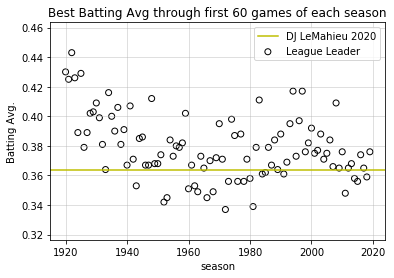

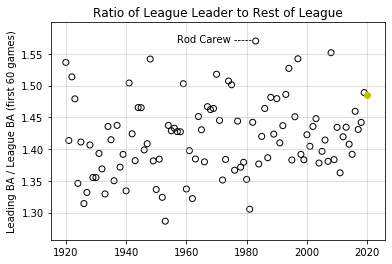

In [323]:
ba_leaders = round((minPA.H.sum() / minPA.AB.sum()), 3).groupby('season').max()
# 2020 MLB BA was .245
plot_2020_vs_hist_with_ratios(ba_leaders, ba60, 0.364, 0.245, 'DJ LeMahieu', 'Batting Avg.',
                             'Leading BA / League BA (first 60 games)',
                             'Best Batting Avg through first 60 games of each season',
                             text=[{'x': 1957, 'y': 1.568, 's': 'Rod Carew -----', 'fontsize': 10}])

#### DJ LeMahieu's .364 average was right in the middle of the historical trend, although when compared to the rest of the league in 2020, it's a more impressive number.

=========== Quick detour to make some frames for external visualization tools =================

In [574]:
bas = minPA.H.sum() / minPA.AB.sum()
bas = bas[bas.groupby('season').transform(lambda x: x == x.max())].to_frame(name='BA')
bas['league'] = ba60.values
bas['ratio'] = bas.BA / bas.league
bas = bas.round(3)
bas.head()

,,BA,league,ratio
season,name,,,
1920,George Sisler,0.430,0.280,1.536
1921,Harry Heilmann,0.425,0.301,1.415
1922,George Sisler,0.443,0.293,1.514
1923,Harry Heilmann,0.426,0.288,1.480
1924,Rogers Hornsby,0.389,0.289,1.347


In [576]:
obps = (minPA.H.sum() + minPA.BB.sum() + minPA.HBP.sum()) / \
                (minPA.AB.sum() + minPA.BB.sum() + \
                 minPA.HBP.sum() + minPA.SF.sum())
obps = obps[obps.groupby('season').transform(lambda x: x == x.max())].to_frame(name='OBP')
obps['league'] = obp60.values
obps['ratio'] = obps.OBP / obps.league
obps = obps.round(3)
obps.head()

,,OBP,league,ratio
season,name,,,
1920,Tris Speaker,0.496,0.345,1.440
1921,Babe Ruth,0.511,0.360,1.419
1922,George Sisler,0.502,0.359,1.400
1923,Babe Ruth,0.529,0.356,1.485
1924,Babe Ruth,0.519,0.354,1.468


In [577]:
slgs = (minPA.H.sum() + minPA['2B'].sum() + 2 * minPA['3B'].sum() + \
           3 * minPA.HR.sum()) / minPA.AB.sum()
slgs = slgs[slgs.groupby('season').transform(lambda x: x == x.max())].to_frame(name='SLG')
slgs['league'] = slg60.values
slgs['ratio'] = slgs.SLG / slgs.league
slgs = slgs.round(3)
slgs.head()

,,SLG,league,ratio
season,name,,,
1920,Babe Ruth,0.772,0.378,2.043
1921,Babe Ruth,0.868,0.425,2.042
1922,Rogers Hornsby,0.702,0.414,1.697
1923,Cy Williams,0.715,0.404,1.769
1924,Babe Ruth,0.727,0.400,1.815


In [581]:
opses = (minPA.H.sum() + minPA.BB.sum() + minPA.HBP.sum()) / \
                (minPA.AB.sum() + minPA.BB.sum() + \
                 minPA.HBP.sum() + minPA.SF.sum()) + \
                ((minPA.H.sum() + minPA['2B'].sum() + \
                 2 * minPA['3B'].sum() + 3 * minPA.HR.sum()) / \
                minPA.AB.sum())
opses = opses[opses.groupby('season').transform(lambda x: x == x.max())].to_frame(name='OPS')
opses['league'] = ops60.values
opses['ratio'] = opses.OPS / opses.league
opses = opses.round(3)
opses.head()

,,OPS,league,ratio
season,name,,,
1920,Babe Ruth,1.250,0.723,1.730
1921,Babe Ruth,1.379,0.785,1.756
1922,Rogers Hornsby,1.186,0.772,1.537
1923,Babe Ruth,1.207,0.760,1.588
1924,Babe Ruth,1.246,0.754,1.652


In [582]:
bas.to_csv('MLB_chartstats/ba_leaders.csv')
obps.to_csv('MLB_chartstats/obp_leaders.csv')
slgs.to_csv('MLB_chartstats/slg_leaders.csv')
opses.to_csv('MLB_chartstats/ops_leaders.csv')

In [583]:
!ls MLB_chartstats/

ba_leaders.csv   leaders60BB.csv  leadersBA.csv    leadersSO.csv
leaders2020.csv  leaders60H.csv   leadersBB.csv    leaguewide_avgs
leaders2B.csv    leaders60HR.csv  leadersH.csv     obp_leaders.csv
leaders3B.csv    leaders60PA.csv  leadersHR.csv    ops_leaders.csv
leaders602B.csv  leaders60R.csv   leadersPA.csv    slg_leaders.csv
leaders603B.csv  leaders60RBI.csv leadersR.csv
leaders60BA.csv  leaders60SO.csv  leadersRBI.csv


In [594]:
## Adding 2020 stat to see it in Tableau
bas.loc[(2020, 'DJ LeMahieu'), 'BA'] = 0.359
bas.loc[(2020, 'DJ LeMahieu'), 'league'] = 0.245
bas.loc[(2020, 'DJ LeMahieu'), 'ratio'] = 1.465

In [602]:
bas.tail()

,,BA,league,ratio
season,name,,,
2016,Daniel Murphy,0.374,0.256,1.459
2017,Ryan Zimmerman,0.365,0.255,1.431
2018,Mookie Betts,0.359,0.249,1.441
2019,Cody Bellinger,0.376,0.253,1.490
2020,DJ LeMahieu,0.359,0.245,1.465


In [603]:
bas.to_csv('MLB_chartstats/ba_leaders.csv')

In [604]:
## Adding 2020 stat to see it in Tableau
obps.loc[(2020, 'Juan Soto'), 'OBP'] = 0.490
obps.loc[(2020, 'Juan Soto'), 'league'] = 0.322
obps.loc[(2020, 'Juan Soto'), 'ratio'] = 1.522
obps.tail()

,,OBP,league,ratio
season,name,,,
2016,Ben Zobrist,0.430,0.324,1.327
2017,Mike Trout,0.461,0.326,1.415
2018,Mike Trout,0.443,0.321,1.381
2019,Mike Trout,0.464,0.326,1.425
2020,Juan Soto,0.490,0.322,1.522


In [605]:
obps.to_csv('MLB_chartstats/obp_leaders.csv')

In [606]:
## Adding 2020 stat to see it in Tableau
slgs.loc[(2020, 'Juan Soto'), 'SLG'] = 0.695
slgs.loc[(2020, 'Juan Soto'), 'league'] = 0.418
slgs.loc[(2020, 'Juan Soto'), 'ratio'] = 1.663
slgs.tail()

,,SLG,league,ratio
season,name,,,
2016,David Ortiz,0.725,0.418,1.733
2017,Mike Trout,0.742,0.426,1.741
2018,Mookie Betts,0.750,0.413,1.815
2019,Cody Bellinger,0.733,0.434,1.692
2020,Juan Soto,0.695,0.418,1.663


In [607]:
slgs.to_csv('MLB_chartstats/slg_leaders.csv')

In [608]:
## Adding 2020 stat to see it in Tableau
opses.loc[(2020, 'Juan Soto'), 'OPS'] = 1.185
opses.loc[(2020, 'Juan Soto'), 'league'] = 0.740
opses.loc[(2020, 'Juan Soto'), 'ratio'] = 1.601
opses.tail()

,,OPS,league,ratio
season,name,,,
2016,David Ortiz,1.149,0.742,1.548
2017,Mike Trout,1.203,0.752,1.600
2018,Mookie Betts,1.187,0.734,1.616
2019,Cody Bellinger,1.195,0.759,1.574
2020,Juan Soto,1.185,0.740,1.601


In [609]:
opses.to_csv('MLB_chartstats/ops_leaders.csv')

Now the summary stats

In [649]:
homer60 = grouped.HR.sum()
triple60 = grouped["3B"].sum()
double60 = grouped['2B'].sum()
hits60 = grouped.H.sum()
walks60 = grouped.BB.sum()
strikeouts60 = grouped.SO.sum()
rbi60 = grouped.RBI.sum()
runs60 = grouped.R.sum()
pas60 = grouped.PA.sum()

In [658]:
statgroups = [homer60, triple60,
              double60, hits60,
              walks60, strikeouts60,
              rbi60, runs60, pas60]
stats = ['HR','3B','2B','H','BB','SO','RBI','R','PA']

In [660]:
for sg, stat in zip(statgroups, stats):
    statDF = sg[sg.groupby('season').transform(lambda x: x == x.max())].to_frame(name=stat)
    statDF.loc[2020, stat] = leaders2020.loc[stat, 'stat']  ## see 2020 frame below
    statDF.to_csv(f'MLB_chartstats/top{stat}60.csv')

In [467]:
leaders2020 = pd.DataFrame(index=['BA','OBP','SLG','OPS','PA','H','2B','3B','HR','BB','SO','RBI','R'],
                          data={'name':['DJ LeMahieu','Juan Soto','Juan Soto','Juan Soto','Marcell Ozuna',
                                       'Trea Turner','Freddie Freeman','Kyle Tucker','Luke Voit',
                                       'Bryce Harper','Miguel Sanó','José Abreu','Freddie Freeman'],
                               'stat':[.364,.490,.695,1.185,267,78,23,6,22,49,90,60,51],
                                'league':[.245,.322,.418,.740,None,None,None,None,None,None,None,None,None]})
leaders2020

,name,stat,league
BA,DJ LeMahieu,0.364,0.245
OBP,Juan Soto,0.490,0.322
SLG,Juan Soto,0.695,0.418
OPS,Juan Soto,1.185,0.740
PA,Marcell Ozuna,267.000,NaN
H,Trea Turner,78.000,NaN
2B,Freddie Freeman,23.000,NaN
3B,Kyle Tucker,6.000,NaN
HR,Luke Voit,22.000,NaN
BB,Bryce Harper,49.000,NaN


In [468]:
leaders2020.to_csv('MLB_chartstats/leaders2020.csv')

============ Now back to the regularly scheduled flow of the notebook ==============

Now how about On-Base Percentage:

In [418]:
print('Juan Soto\'s OBP was .490 in 2020.  \nHere are the top season starts historically:')
round((minPA.H.sum() + minPA.BB.sum() + minPA.HBP.sum()) / 
                (minPA.AB.sum() + minPA.BB.sum() + 
                 minPA.HBP.sum() + minPA.SF.sum()), 3).sort_values(ascending=False).head(30).to_frame(name='OBP')

Juan Soto's OBP was .490 in 2020.  
Here are the top season starts historically:


,,OBP
season,name,
2004,Barry Bonds,0.626
2002,Barry Bonds,0.563
1948,Ted Williams,0.545
1931,Babe Ruth,0.540
1923,Babe Ruth,0.529
1957,Mickey Mantle,0.528
1941,Ted Williams,0.527
1930,Babe Ruth,0.522
1925,Rogers Hornsby,0.520


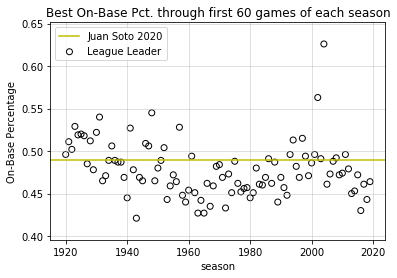

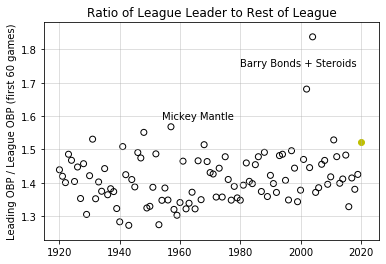

In [324]:
'''
OBP = (H + BB + HBP) / (AB + BB + HBP + SF) ==> on-base %, as stated on bb-ref site.  
total_bases = H + 2B + 2*3B + 3*HR  ==> since there's no "1B" column here
SLG = total_bases/ AB
OPS = OBP + SLG
'''
obp_leaders = round((minPA.H.sum() + minPA.BB.sum() + minPA.HBP.sum()) / 
                (minPA.AB.sum() + minPA.BB.sum() + 
                 minPA.HBP.sum() + minPA.SF.sum()), 3).groupby('season').max()
# 2020 MLB OBP was .322, and obp60 (the league totals per year) was calculated earlier
plot_2020_vs_hist_with_ratios(obp_leaders, obp60, 0.490, 0.322, 'Juan Soto', 'On-Base Percentage',
                             'Leading OBP / League OBP (first 60 games)',
                             'Best On-Base Pct. through first 60 games of each season',
                             text = [{'x': 1980, 'y': 1.75, 's': 'Barry Bonds + Steroids',
                                    'fontsize': 10}, {'x': 1954, 'y': 1.59, 's': 'Mickey Mantle',
                                                     'fontsize': 10}])

#### The .490 rate that Juan Soto reached base this year is the best start since 2011, and it joins José Bautista's 2011 number as one of the top 5 non-steroid numbers of the past century, compared to the rest of the league in its respective year.  

In [419]:
print('Juan Soto\'s Slugging Pct. was .695 in 2020.  \nHere are the top season starts historically:')
round((minPA.H.sum() + minPA['2B'].sum() + 2 * minPA['3B'].sum() +
           3 * minPA.HR.sum()) / minPA.AB.sum(), 3).sort_values(ascending=False).head(30).to_frame(name='SLG')

Juan Soto's Slugging Pct. was .695 in 2020.  
Here are the top season starts historically:


,,SLG
season,name,
2001,Barry Bonds,0.926
1921,Babe Ruth,0.868
1998,Mark McGwire,0.830
2004,Barry Bonds,0.828
2002,Barry Bonds,0.827
2000,Barry Bonds,0.815
1930,Babe Ruth,0.803
1928,Babe Ruth,0.799
1956,Mickey Mantle,0.795


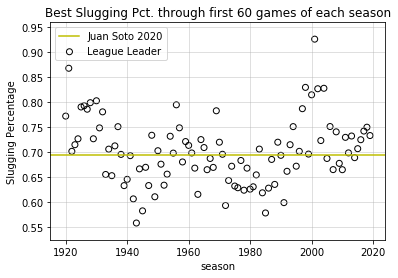

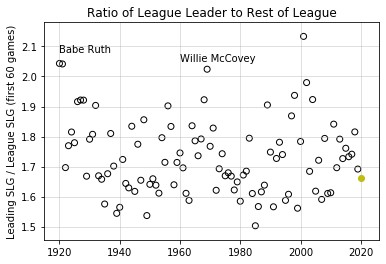

In [325]:
'''
OBP = (H + BB + HBP) / (AB + BB + HBP + SF) ==> on-base %, as stated on bb-ref site.  
total_bases = H + 2B + 2*3B + 3*HR  ==> since there's no "1B" column here
SLG = total_bases/ AB
OPS = OBP + SLG
'''
slg_leaders = ((minPA.H.sum() + minPA['2B'].sum() + 2 * minPA['3B'].sum() +
           3 * minPA.HR.sum()) / minPA.AB.sum()).groupby('season').max()
# 2020 MLB SLG% was .418, and slg60 (league totals for slugging thru 60 games each season) was done earlier.
plot_2020_vs_hist_with_ratios(slg_leaders, slg60, 0.695, 0.418, 'Juan Soto', 'Slugging Percentage',
                             'Leading SLG / League SLG (first 60 games)',
                             'Best Slugging Pct. through first 60 games of each season',
                             text = [{'x': 1920, 'y': 2.08, 's': 'Babe Ruth',
                                    'fontsize': 10}, {'x': 1960, 'y': 2.05, 
                                                      's': 'Willie McCovey',
                                                      'fontsize': 10}])


#### Juan Soto slugged .695 in 2020, which was a little low for the last decade, but very much in line with the last century.

For individual batting leaders in 2020, the numbers weren't too crazy.  Even Miguel Sanó's awful strikeout total was only the 3rd worst of the last decade. Probably the most standout stat is Juan Soto's .490 OBP, especially when you look at it compared to the rest of 2020 MLB, and even moreso when you consider he slugged .695 as well.  That (.490 + .695 = ) 1.185 OPS is probably pretty remarkable historically, so let's see:

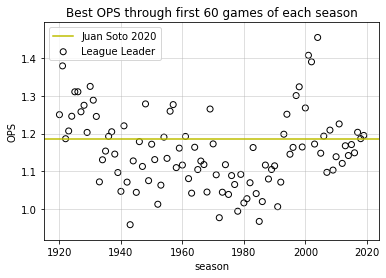

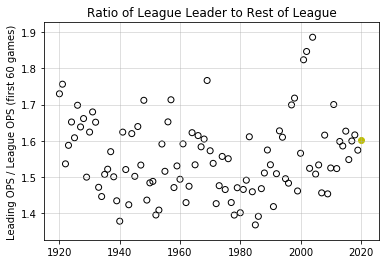

In [327]:
ops_leaders = ((minPA.H.sum() + minPA.BB.sum() + minPA.HBP.sum()) / 
                (minPA.AB.sum() + minPA.BB.sum() + 
                 minPA.HBP.sum() + minPA.SF.sum()) + 
               ((minPA.H.sum() + minPA['2B'].sum() + 
                 2 * minPA['3B'].sum() + 3 * minPA.HR.sum()) / 
                minPA.AB.sum())).groupby('season').max()
# MLB 2020 OPS overall was .740, and ops60 (historical ops for MLB each year thru 60 games) was done above
plot_2020_vs_hist_with_ratios(ops_leaders, ops60, 1.185, 0.740, 'Juan Soto', 'OPS',
                             'Leading OPS / League OPS (first 60 games)',
                             'Best OPS through first 60 games of each season')    

#### Well, not as remarkable as I suspected.  Very good OPS, but very typical when you compare it to past leaders as well as when you first put it in the context of the rest of the league for its year.  I'm not a baseball stats nut, but if I were, I don't think I'd pay much attention to OPS.  Juan Soto's OBP was more outstanding than his slugging % this year, and looking at the OPS obscures that fact, since the slugging component of the OPS seems to be much more important than the OBP component.

Possible next directions to go:  
-- Team stats  
-- Pitching stats  
-- Analysis of variance for each stat (at-bat, game, season, career, team)